In [15]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.Functions.functions import *

choose a player from all the league

In [4]:
player = "L. James"

Here, we analyse in each match the actions of the player

In [5]:
with open('Data/NBA_Matches_Stats.json') as f:
    data = json.load(f)

points = []
df = pd.DataFrame()
for d in data:
    for action in d["playByPlay"]["actions"]:
        if "Shot" in action['actionType']:
            if action["playerNameI"] == player:
                df = pd.concat([df, pd.DataFrame(action, index=[0])], ignore_index=True)

df = df.rename(columns={"actionType": "Shot Type"})


With that information, we can show all the shot he has tried and made

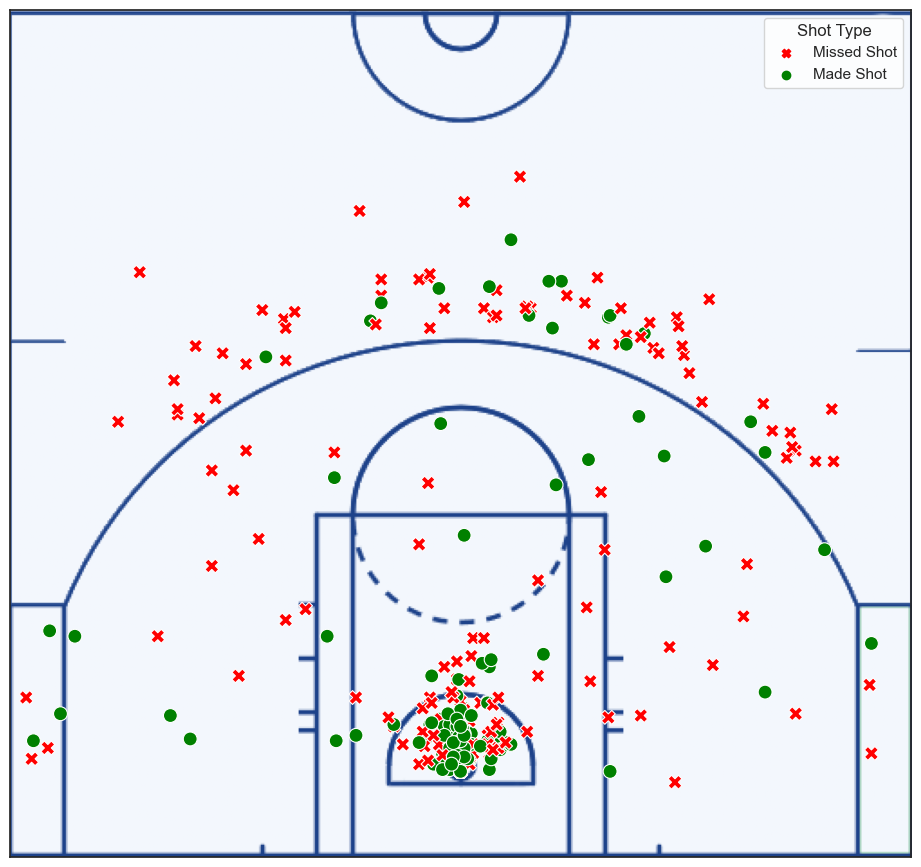

In [9]:
# change palette

img = plt.imread("Images/court.png")
fig, ax = plt.subplots(figsize=(12, 11))
ax.imshow(img, extent=[-270, 270, -67.5, 442.5])
# plot the shots
sns.set_theme(style="white", palette="muted", color_codes=True)
sns.scatterplot(x="xLegacy", y="yLegacy", data=df, hue="Shot Type", style="Shot Type", s=100, legend=True,
                palette=["red", "green"], style_order=["Made Shot", "Missed Shot"])
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

plt.show()

We can also see compared to the average shoot success of the league

SHOT_ZONE_BASIC
Above the Break 3        0.347373
In The Paint (Non-RA)    0.413129
Left Corner 3            0.397296
Mid-Range                0.414488
Restricted Area          0.649456
Right Corner 3           0.369432
Name: FG%, dtype: float64
zone
Above the Break 3        0.230769
In The Paint (Non-RA)    0.437500
Left Corner 3            0.333333
Mid-Range                0.388889
Restricted Area          0.663551
Right Corner 3           0.500000
dtype: float64


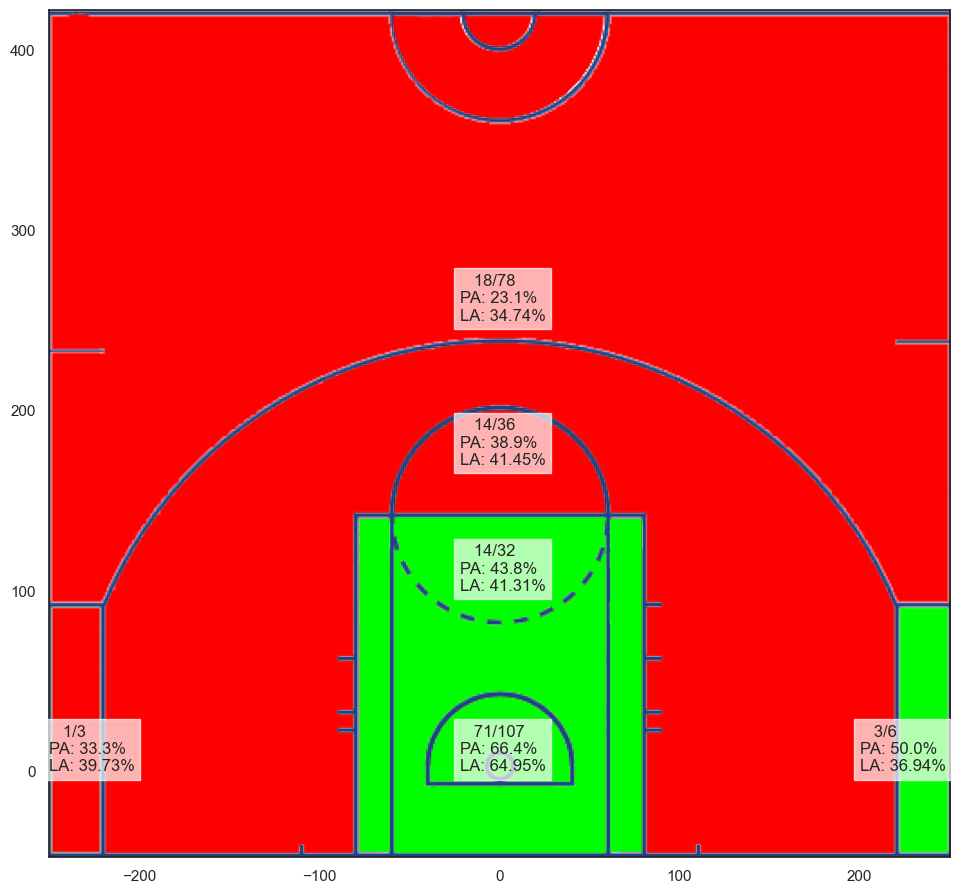

In [18]:

# add if the shot is a 3 pointer or not
df["zone"] = df.apply(lambda r: get_zone_(r), axis=1)

images = [(plt.imread("Images/court-top.png")), plt.imread("Images/court-inside.png"),
          plt.imread("Images/court-bottom-left.png"),
          plt.imread("Images/court-2points.png"),
          plt.imread("Images/court-hoop.png"), plt.imread("Images/court-bottom-right.png")]

# check the accuracy of each zones
zones = df.groupby(["zone", "Shot Type"]).agg({"Shot Type": "count"})
percent = zones["Shot Type"].unstack()["Made Shot"] / (
        zones["Shot Type"].unstack()["Missed Shot"] + zones["Shot Type"].unstack()["Made Shot"])

with open('Data/LeagueAverage.json') as f:
    league_avg = json.load(f)

league_avg = clean_league_avg(league_avg)

print(league_avg)
fig, ax = plt.subplots(figsize=(12, 11))
img = plt.imread("Images/court.png")
ax.imshow(img, extent=[-270, 270, -67.5, 442.5])

for id in range(len(images)):
    for i in images[id]:
        for j in i:
            if j[3] != 0:
                if (float(percent[id])) > float(league_avg[id]):
                    j[0] = j[2] = 0
                else:
                    j[2] = j[1] = 0

    ax.imshow(images[id], extent=[-270, 270, -67.5, 442.5])

add_text(ax,zones,league_avg,percent)
plt.xlim(-250, 250)
plt.ylim(-47.5, 422.5)

plt.show()

In [12]:
df = pd.read_csv("Data/NBA_Players_Stats.csv")

df[df["POSITION"].isna()]

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,CFID,CFPARAMS,POSITION
1,1631260,AJ Green,AJ,1610612749,MIL,23.0,3,3,0,1.00,...,433,434,331,428,144,13,427,5,"1631260,1610612749",NaN
125,1630696,Dru Smith,Dru,1610612748,MIA,24.0,1,1,0,1.00,...,433,441,264,444,144,13,444,5,"1630696,1610612748",NaN
237,1630648,Jordan Schakel,Jordan,1610612764,WAS,24.0,2,0,2,0.00,...,409,434,194,442,144,13,439,5,"1630648,1610612764",NaN
245,1630563,Joshua Primo,Joshua,1610612759,SAS,19.0,4,3,1,0.75,...,282,352,236,357,144,13,346,5,"1630563,1610612759",NaN
327,1630701,Michael Foster Jr.,Michael,1610612755,PHI,19.0,1,1,0,1.00,...,433,450,236,459,144,13,459,5,"1630701,1610612755",NaN
